In [1]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd


In [4]:
# Load the Pavia University hyperspectral image and ground truth
data = sio.loadmat('/content/PaviaU.mat')['paviaU']
labels = sio.loadmat('/content/PaviaU_gt.mat')['paviaU_gt']

# Print data shapes
print("Original Data Shape:", data.shape)       # Expected: (610, 340, 103)
print("Ground Truth Shape:", labels.shape)      # Expected: (610, 340)


Original Data Shape: (610, 340, 103)
Ground Truth Shape: (610, 340)


In [5]:
# Reshape data (flatten spatial dimensions)
X = data.reshape(-1, data.shape[2])               # (10249, 200)
y = labels.reshape(-1)                            # (10249,)

# Remove zero-labeled pixels (background)
mask = y > 0
X = X[mask]
y = y[mask]

print("Reshaped Data (X):", X.shape)
print("Ground Truth Labels (y):", y.shape)
print("Unique Classes:", np.unique(y))            # [1, 2, ..., 16]

# PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
print("PCA Reduced Shape:", X_pca.shape)

# Normalize data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_pca)
print("Normalized Data Shape:", X_norm.shape)

# One-hot encoding of labels
y_encoded = to_categorical(y - 1)                 # Adjust labels to start from 0
print("One-Hot Encoded Labels Shape:", y_encoded.shape)


Reshaped Data (X): (42776, 103)
Ground Truth Labels (y): (42776,)
Unique Classes: [1 2 3 4 5 6 7 8 9]
PCA Reduced Shape: (42776, 50)
Normalized Data Shape: (42776, 50)
One-Hot Encoded Labels Shape: (42776, 9)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_encoded, test_size=0.30, random_state=42, stratify=y
)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (29943, 50)
Testing Data Shape: (12833, 50)


In [9]:
# Build the DNN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(9, activation='softmax')  # 16 output classes
])

print(model.summary())

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,369 (60.04 KB)

 Trainable params: 15,369 (60.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
936/936 - 9s - 10ms/step - accuracy: 0.7314 - loss: 0.7625 - val_accuracy: 0.8770 - val_loss: 0.3233
Epoch 2/20
936/936 - 3s - 3ms/step - accuracy: 0.8693 - loss: 0.3594 - val_accuracy: 0.9186 - val_loss: 0.2268
Epoch 3/20
936/936 - 3s - 3ms/step - accuracy: 0.8989 - loss: 0.2773 - val_accuracy: 0.9277 - val_loss: 0.1952
Epoch 4/20
936/936 - 5s - 5ms/step - accuracy: 0.9122 - loss: 0.2400 - val_accuracy: 0.9338 - val_loss: 0.1760
Epoch 5/20
936/936 - 3s - 3ms/step - accuracy: 0.9216 - loss: 0.2182 - val_accuracy: 0.9388 - val_loss: 0.1607
Epoch 6/20
936/936 - 5s - 5ms/step - accuracy: 0.9285 - loss: 0.1972 - val_accuracy: 0.9417 - val_loss: 0.1496
Epoch 7/20
936/936 - 6s - 6ms/step - accuracy: 0.9334 - loss: 0.1814 - val_accuracy: 0.9424 - val_loss: 0.1509
Epoch 8/20
936/936 - 3s - 3ms/step - accuracy: 0.9341 - loss: 0.1782 - val_accuracy: 0.9429 - val_loss: 0.1450
Epoch 9/20
936/936 - 5s - 6ms/step - accuracy: 0.9377 - loss: 0.1711 - val_accuracy: 0.9441 - val_loss: 0.

In [10]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 94.77%


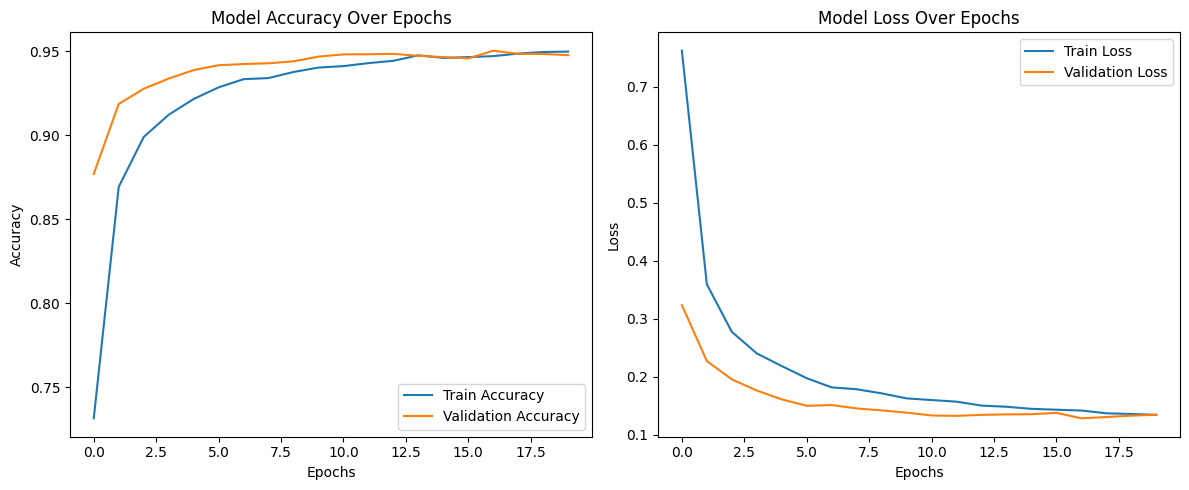

In [11]:
# Plotting Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x800 with 0 Axes>

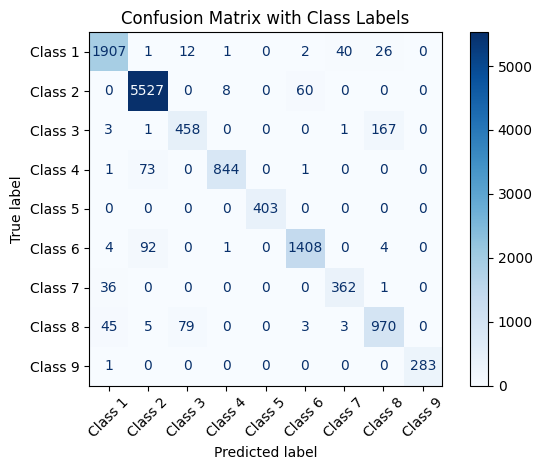

In [13]:
# Get model predictions
y_pred_probs = model.predict(X_test)  # Get probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
class_names = [f"Class {i+1}" for i in range(9)]

# Get true labels (convert from one-hot encoding)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix with class names
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')

plt.title('Confusion Matrix with Class Labels')
plt.tight_layout()
plt.show()


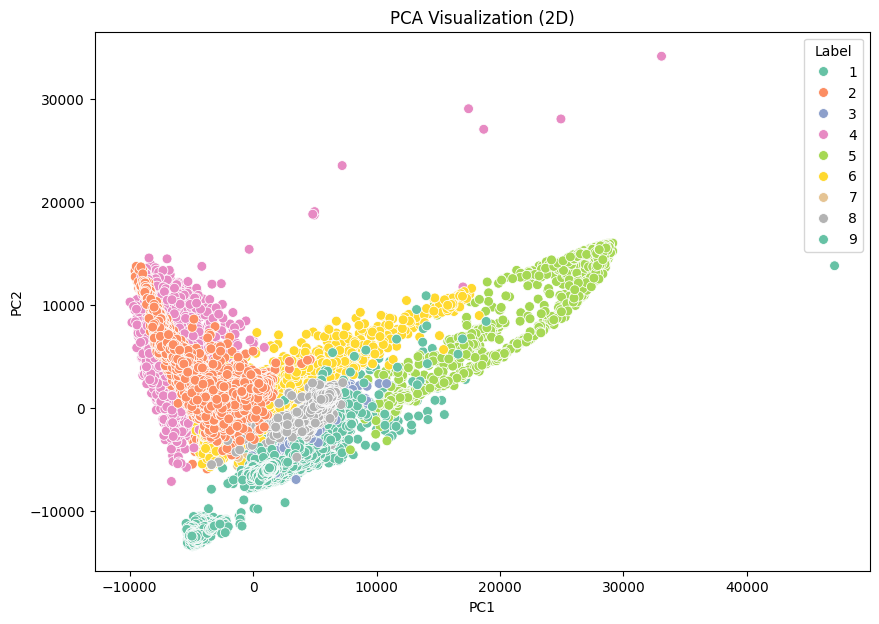

In [14]:
# 2D PCA Visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10, 7))
df = pd.DataFrame({'PC1': X_pca_2d[:, 0], 'PC2': X_pca_2d[:, 1], 'Label': y})
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set2', legend='full', s=50)
plt.title('PCA Visualization (2D)')
plt.show()


In [15]:
from sklearn.metrics import classification_report

# Compute and display precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1989
           1       0.97      0.99      0.98      5595
           2       0.83      0.73      0.78       630
           3       0.99      0.92      0.95       919
           4       1.00      1.00      1.00       403
           5       0.96      0.93      0.94      1509
           6       0.89      0.91      0.90       399
           7       0.83      0.88      0.85      1105
           8       1.00      1.00      1.00       284

    accuracy                           0.95     12833
   macro avg       0.94      0.92      0.93     12833
weighted avg       0.95      0.95      0.95     12833

